In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import spikeData
from preprocess import *
from models import AE, VAE
from clustering import *
from utils import *
import random
from tqdm import tqdm

d:\Applications\anaconda3\envs\ag\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
si.__version__

'0.101.0'

## File Path Definition 

In [4]:
# Specify the source directory
source_dir = r'H:\Work\SpikeSorting\kiehnlab\Treadmill_clustered_txt'

# Ensure the directory exists
if not os.path.exists(source_dir):
    raise ValueError(f"Directory '{source_dir}' does not exist")

# Initialize an empty list to store paths
file_paths = []
res_paths = []
# List all files in the source directory
files = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

# Store the full paths in a list
for file_name in files:
    file_path = os.path.join(os.path.join(source_dir, file_name), file_name+'.tev')
    res_path = os.path.join(os.path.join(source_dir, file_name), file_name+'.txt')
    file_paths.append(file_path)
    res_paths.append(res_path)

In [ ]:
files[20]

'Rec_treadmill_haloperidol_xx_-220317_Vglut2-ChR2-36_-220317-080745'

## Config Set

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

i = 20
job_kwargs = dict(n_jobs=4, chunk_duration='1s',  progress_bar=True)
base_folder = os.path.join(source_dir, files[i])
config = {
        'data': file_paths[i],
        'res': res_paths[i],
        'output': None,
        'thresh': 0.0,
        'cutoff': 0.5,
        'poff': 12,
        'noff': 8,
        'corr': 0.0,
        'mask': True,
        'kmeans': False,
        'jigsaw': False,
        'shuffle': False,
        'epochs': 20,
        'hidden': 2048,
        'latent': 8,
        'batch': 1024,
        'lr': 1e-4,
        'clusters': 8,
        'save': True,
        'denoise': True,
        'reprocess': False,
        'retrain': False,
        'model': '../models/model_H_2048L_8_VAE_alldata_0529_shuffle.pt'
    }

cuda


In [7]:
manual_res = pd.read_csv(res_paths[i],delimiter=',',skiprows=2,usecols=[0,2],names = ['time','cluster'],header=None)
manual_res = manual_res[manual_res['cluster'] != 0]
print(len(manual_res))
print(manual_res.cluster.unique())

12307
[3 1 2 5]


## Use Deep-Spike to Reduce Dimension

In [8]:
all_emb, all_xdata, all_evSeq,fs = encode_func(config = config,threshold_s = 6,device = device)

Using mask pretext
Found 709 events at 0.81 threshold
Using kmeans clustering...


d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Found 2 clusters
Using mask pretext
Found 8760 events at 0.71 threshold
Using kmeans clustering...
Found 2 clusters
Using mask pretext
Found 11262 events at 0.60 threshold


d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Using kmeans clustering...
Found 2 clusters


d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


## Cluster with different method

In [ ]:
method_lists = [('bic','gmm'),(None,'dpgmm'),(None,'hdbscan')]
cls_labels_list = []
for method in method_lists:
    cls_labels,_,_ = make_clusters(all_emb,nClus= len(manual_res['cluster'].unique())+2,method= method[1],automated = method[0])
    cls_labels_list.append(cls_labels)

Using GMM with BIC/AIC!


d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is k

Found 5 clusters
Using DPGMM!


d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
d:\Applications\anaconda3\envs\ag\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is k

Found 6 clusters
Using HDBSCAN clustering...
Found 3 clusters


## Visualization with one method and generate sorting result

In [10]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

Using PCA for final visualization
K=1, N=4714
K=2, N=4162
K=3, N=3512
K=4, N=1631
K=5, N=1476
K=6, N=1370


h:\Work\SpikeSorting\deepspike-master\FINAL\clustering.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

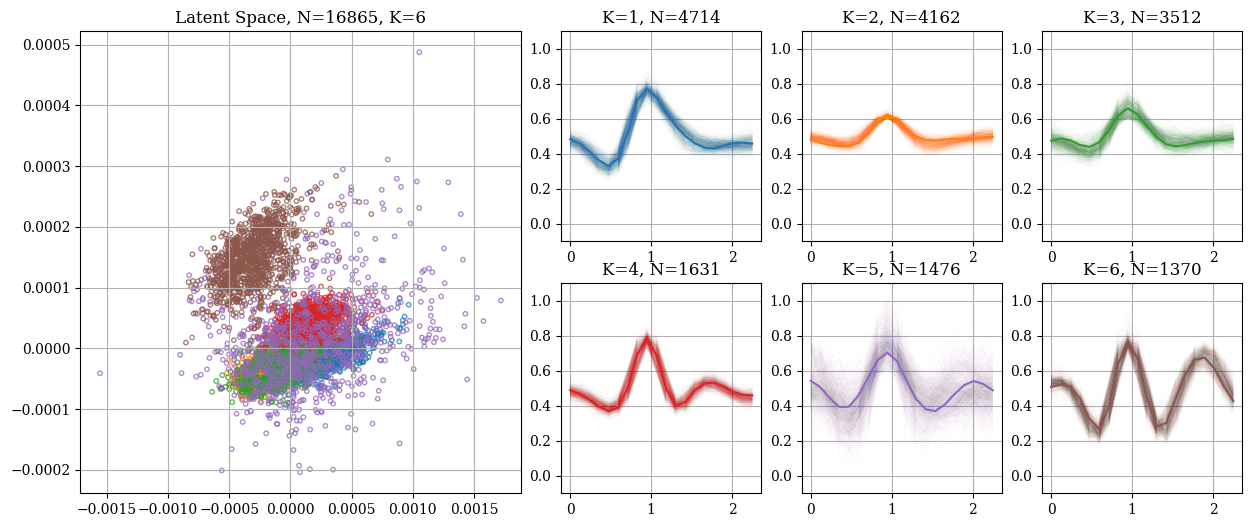

In [11]:
cls_labels, clusters, counts, ordClsLabels, embeddings  = draw_clustering(all_xdata,all_emb,cls_labels_list[1],method='pca',draw=True)

In [12]:
df = output_df(config,fs, embeddings, all_xdata, all_evSeq, cls_labels)

In [13]:
df

,peak_id,emb_x,emb_y,cluster,time_ms
0,2104,0.000228,-5.144330e-07,1,8.617984e+01
1,3511,0.000277,3.136886e-05,4,1.438106e+02
2,5117,-0.000167,-6.064508e-05,1,2.095923e+02
3,7939,-0.000060,-2.136090e-05,3,3.251814e+02
4,7976,0.000071,-3.836568e-05,1,3.266970e+02
...,...,...,...,...,...
16860,49953178,0.000288,-3.499965e-06,1,2.046082e+06
16861,49953779,0.000016,-4.234187e-05,3,2.046107e+06
16862,49956232,-0.000145,-4.624055e-05,2,2.046207e+06
16863,49956647,-0.000269,-1.071985e-04,3,2.046224e+06


In [11]:
# df.to_csv('sorting_result.csv',index=False,float_format='%.4f')

d:\Applications\anaconda3\envs\ag\lib\site-packages\neo\rawio\tdtrawio.py:293: UserWarning: Could not identify sev files for channels [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8].
  warnings.warn(f"Could not identify sev files for channels {missing_sev_channels}.")


TdtRecordingExtractor: 1 channels - 24.4kHz - 1 segments - 49,977,344 samples 
                       2,047.07s (34.12 minutes) - float32 dtype - 190.65 MiB
Number of channels = 1
Sampling frequency = 24414.0625 Hz
Number of segments= 1
Number of timepoints in seg0= 49977344


d:\Applications\anaconda3\envs\ag\lib\site-packages\neo\rawio\tdtrawio.py:293: UserWarning: Could not identify sev files for channels [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8].
  warnings.warn(f"Could not identify sev files for channels {missing_sev_channels}.")


PERFORMANCE (pooled_with_average)
-----------
ACCURACY: 56.87744770591069
RECALL: 68.84678710999898
PRECISION: 78.6111051149145
FALSE DISCOVERY RATE: 21.388894885085513
MISS RATE: 31.153212890001008

SUMMARY
-------
GT num_units: 4
TESTED num_units: 6
num_well_detected: 0
num_redundant: 1
num_overmerged: 3
num_false_positive_units 1
num_bad: 4



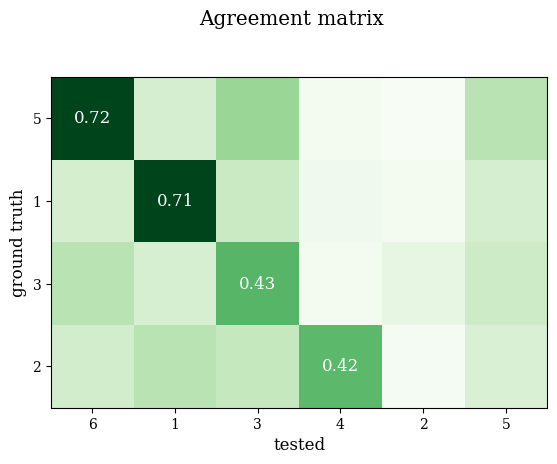

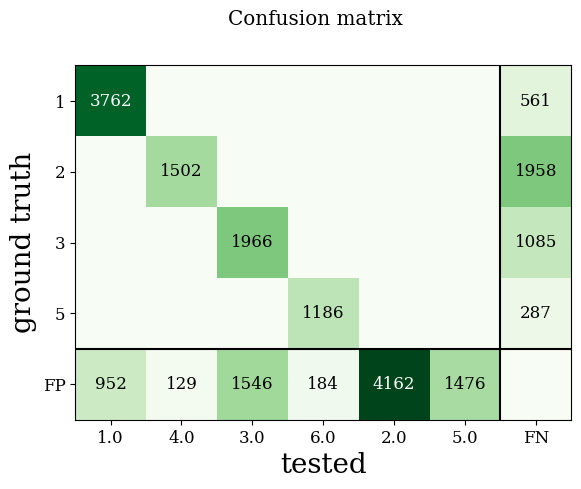

In [14]:
sorting_true,sorting_deep,recording_f,perf, comp = compare_sorters_vivo(config,df)

# Get All Cluster method's result into spikeinterface 

d:\Applications\anaconda3\envs\ag\lib\site-packages\neo\rawio\tdtrawio.py:293: UserWarning: Could not identify sev files for channels [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8].
  warnings.warn(f"Could not identify sev files for channels {missing_sev_channels}.")


TdtRecordingExtractor: 1 channels - 24.4kHz - 1 segments - 49,977,344 samples 
                       2,047.07s (34.12 minutes) - float32 dtype - 190.65 MiB
Number of channels = 1
Sampling frequency = 24414.0625 Hz
Number of segments= 1
Number of timepoints in seg0= 49977344


d:\Applications\anaconda3\envs\ag\lib\site-packages\neo\rawio\tdtrawio.py:293: UserWarning: Could not identify sev files for channels [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8].
  warnings.warn(f"Could not identify sev files for channels {missing_sev_channels}.")


PERFORMANCE (pooled_with_average)
-----------
ACCURACY: 52.7897080788744
RECALL: 71.72276417693202
PRECISION: 66.12922719919862
FALSE DISCOVERY RATE: 33.870772800801376
MISS RATE: 28.277235823067983

SUMMARY
-------
GT num_units: 4
TESTED num_units: 5
num_well_detected: 0
num_redundant: 1
num_overmerged: 3
num_false_positive_units 0
num_bad: 3



d:\Applications\anaconda3\envs\ag\lib\site-packages\spikeinterface\core\base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.100.6 is recommended
  warnings.warn(
d:\Applications\anaconda3\envs\ag\lib\site-packages\spikeinterface\core\waveforms_extractor_backwards_compatibility.py:621: UserWarning: Removing legacy parameter sparsity from quality_metrics extension
  warnings.warn(f"Removing legacy parameter {p} from {old_name} extension")
d:\Applications\anaconda3\envs\ag\lib\site-packages\spikeinterface\core\waveforms_extractor_backwards_compatibility.py:621: UserWarning: Removing legacy parameter random_chunk_kwargs_dict from quality_metrics extension
  warnings.warn(f"Removing legacy parameter {p} from {old_name} extension")
d:\Applications\anaconda3\envs\ag\lib\site-packages\neo\rawio\tdtrawio.py:293: UserWarning: Could not identify sev files for channels [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8].
  warnings.warn(f"Could not 

TdtRecordingExtractor: 1 channels - 24.4kHz - 1 segments - 49,977,344 samples 
                       2,047.07s (34.12 minutes) - float32 dtype - 190.65 MiB
Number of channels = 1
Sampling frequency = 24414.0625 Hz
Number of segments= 1
Number of timepoints in seg0= 49977344


d:\Applications\anaconda3\envs\ag\lib\site-packages\neo\rawio\tdtrawio.py:293: UserWarning: Could not identify sev files for channels [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8].
  warnings.warn(f"Could not identify sev files for channels {missing_sev_channels}.")
d:\Applications\anaconda3\envs\ag\lib\site-packages\spikeinterface\core\base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.100.6 is recommended
  warnings.warn(


PERFORMANCE (pooled_with_average)
-----------
ACCURACY: 56.87744770591069
RECALL: 68.84678710999898
PRECISION: 78.6111051149145
FALSE DISCOVERY RATE: 21.388894885085513
MISS RATE: 31.153212890001008

SUMMARY
-------
GT num_units: 4
TESTED num_units: 6
num_well_detected: 0
num_redundant: 1
num_overmerged: 3
num_false_positive_units 1
num_bad: 4



d:\Applications\anaconda3\envs\ag\lib\site-packages\spikeinterface\core\waveforms_extractor_backwards_compatibility.py:621: UserWarning: Removing legacy parameter sparsity from quality_metrics extension
  warnings.warn(f"Removing legacy parameter {p} from {old_name} extension")
d:\Applications\anaconda3\envs\ag\lib\site-packages\spikeinterface\core\waveforms_extractor_backwards_compatibility.py:621: UserWarning: Removing legacy parameter random_chunk_kwargs_dict from quality_metrics extension
  warnings.warn(f"Removing legacy parameter {p} from {old_name} extension")
d:\Applications\anaconda3\envs\ag\lib\site-packages\neo\rawio\tdtrawio.py:293: UserWarning: Could not identify sev files for channels [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8].
  warnings.warn(f"Could not identify sev files for channels {missing_sev_channels}.")


TdtRecordingExtractor: 1 channels - 24.4kHz - 1 segments - 49,977,344 samples 
                       2,047.07s (34.12 minutes) - float32 dtype - 190.65 MiB
Number of channels = 1
Sampling frequency = 24414.0625 Hz
Number of segments= 1
Number of timepoints in seg0= 49977344


d:\Applications\anaconda3\envs\ag\lib\site-packages\neo\rawio\tdtrawio.py:293: UserWarning: Could not identify sev files for channels [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8].
  warnings.warn(f"Could not identify sev files for channels {missing_sev_channels}.")


confusion matrix failed
PERFORMANCE (pooled_with_average)
-----------
ACCURACY: 24.608569364857967
RECALL: 84.44541207479115
PRECISION: 26.59349524002863
FALSE DISCOVERY RATE: 73.40650475997137
MISS RATE: 15.554587925208851

SUMMARY
-------
GT num_units: 4
TESTED num_units: 3
num_well_detected: 0
num_redundant: 0
num_overmerged: 1
num_false_positive_units 1
num_bad: 3



d:\Applications\anaconda3\envs\ag\lib\site-packages\spikeinterface\core\base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.100.6 is recommended
  warnings.warn(


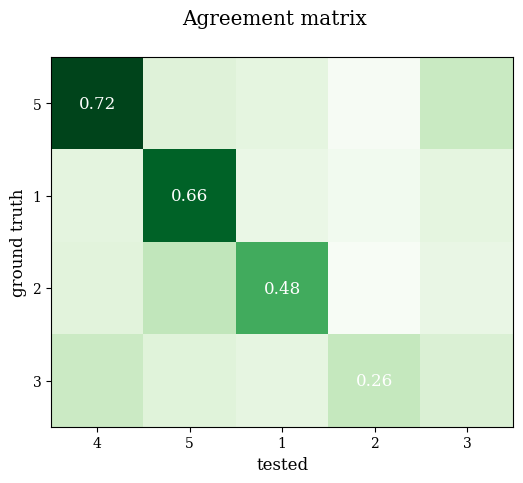

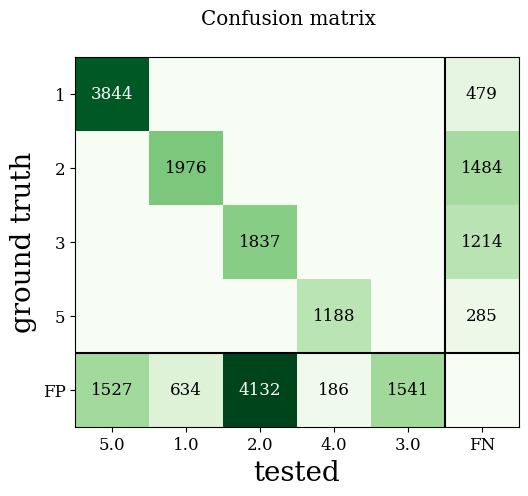

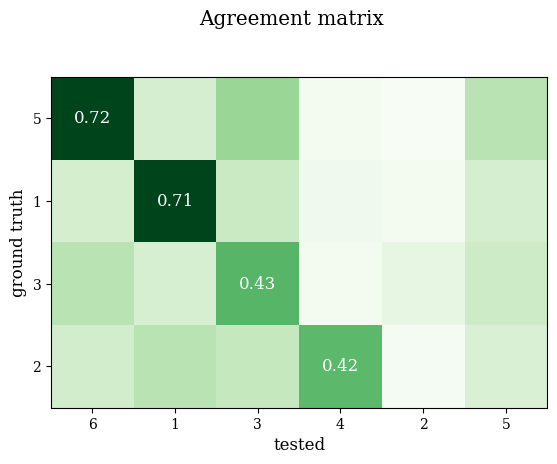

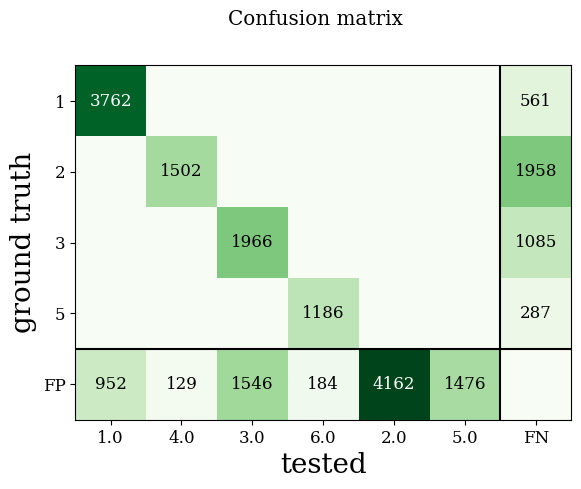

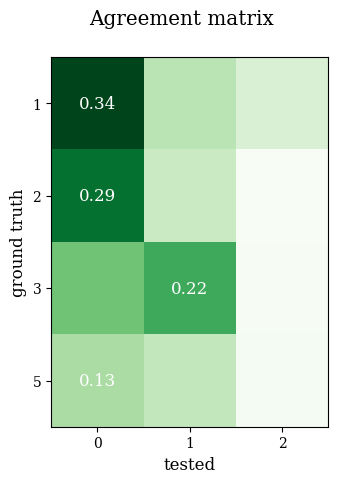

In [15]:
sortings_deep = {}
perfs = {}
comps = {}
wes_deep = {}
for i,name in enumerate(method_lists):
    cls_labels, clusters, counts, ordClsLabels, embeddings  = draw_clustering(all_xdata,all_emb,cls_labels_list[i],method='pca',draw=False)
    df = output_df(config,fs, embeddings, all_xdata, all_evSeq, cls_labels)
    sorting_true,sortings_deep[name],recording_f,perfs[name], comps[name] = compare_sorters_vivo(config,df)
    try:
        wes_deep[name] = si.load_waveforms(os.path.join(base_folder,f"waveforms_{name}"))
    except:
        wes_deep[name] = si.extract_waveforms(recording_f, sortings_deep[name], folder=os.path.join(base_folder,f"waveforms_{name}"),overwrite = True, sparse=False,**job_kwargs)

In [18]:
import spikeinterface.qualitymetrics as sq
metrics = sq.compute_quality_metrics(wes_deep[('bic','gmm')])
metrics

d:\Applications\anaconda3\envs\eeg\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:702: UserWarning: 
  warnings.warn("")
d:\Applications\anaconda3\envs\eeg\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1429: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(


,amplitude_cutoff,amplitude_cv,amplitude_median,firing_range,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8
1,0.010296,NaN,17.151636,3.72,1.274992,5.208758,52.0,2610.0,1.0,1.0,32.0,NaN,NaN,3.455217,0.0,0.0,0.0
2,0.000518,NaN,14.440718,5.80,2.915872,1.551293,81.0,5969.0,1.0,1.0,45.0,NaN,NaN,2.050365,0.0,0.0,0.0
3,0.009752,NaN,54.206390,4.60,0.752783,73.848166,257.0,1541.0,1.0,1.0,167.0,NaN,NaN,3.738010,0.0,0.0,0.0
4,0.009967,NaN,137.435287,2.80,0.671203,0.722884,2.0,1374.0,1.0,1.0,1.0,NaN,NaN,12.705709,0.0,0.0,0.0
5,0.009687,NaN,20.552874,6.00,2.623747,2.318076,98.0,5371.0,1.0,1.0,40.0,NaN,NaN,6.353869,0.0,0.0,0.0


In [20]:
metrics.to_csv('sorting_metrics.csv',index=False)

In [19]:
import spikeinterface.qualitymetrics as sq
metrics = sq.compute_quality_metrics(wes_deep[ (None, 'dpgmm')])
metrics

d:\Applications\anaconda3\envs\eeg\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:702: UserWarning: 
  warnings.warn("")
d:\Applications\anaconda3\envs\eeg\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1429: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(


,amplitude_cutoff,amplitude_cv,amplitude_median,firing_range,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8
1,0.009913,NaN,19.058130,5.20,2.302801,1.566040,51.0,4714.0,1.0,1.000000,22.0,NaN,NaN,6.828685,0.0,0.0,0.0
2,0.005985,NaN,12.157749,4.52,2.033148,0.748447,19.0,4162.0,1.0,0.804342,8.0,NaN,0.185,2.228714,0.0,0.0,0.0
3,0.000543,NaN,24.720421,5.92,1.715621,7.911137,143.0,3512.0,1.0,1.000000,99.0,NaN,NaN,3.946248,0.0,0.0,0.0
4,0.005443,NaN,12.464057,2.40,0.796748,0.256510,1.0,1631.0,1.0,0.533959,1.0,NaN,0.260,4.760143,0.0,0.0,0.0
5,0.004795,NaN,55.131229,4.40,0.721030,73.604948,235.0,1476.0,1.0,1.000000,156.0,NaN,NaN,4.248426,0.0,0.0,0.0
6,0.011575,NaN,136.864716,2.80,0.669249,1.090667,3.0,1370.0,1.0,1.000000,1.0,NaN,NaN,12.728594,0.0,0.0,0.0


In [15]:
wes_deep[('bic','gmm')]

WaveformExtractor: 1 channels - 5 units - 1 segments
  before:24 after:48 n_per_units:500

In [13]:
sortings_deep

{('bic', 'gmm'): NumpySorting: 5 units - 1 segments - 24.4kHz,
 (None, 'dpgmm'): NumpySorting: 6 units - 1 segments - 24.4kHz,
 (None, 'hdbscan'): NumpySorting: 3 units - 1 segments - 24.4kHz}

## Comparision with different clustering mehtod

Using PCA for final visualization
Silhouette Score for Clustering GMM: 0.1351
Silhouette Score for Clustering DPGMM: 0.0291
Silhouette Score for Clustering HDBSCAN: -0.1006


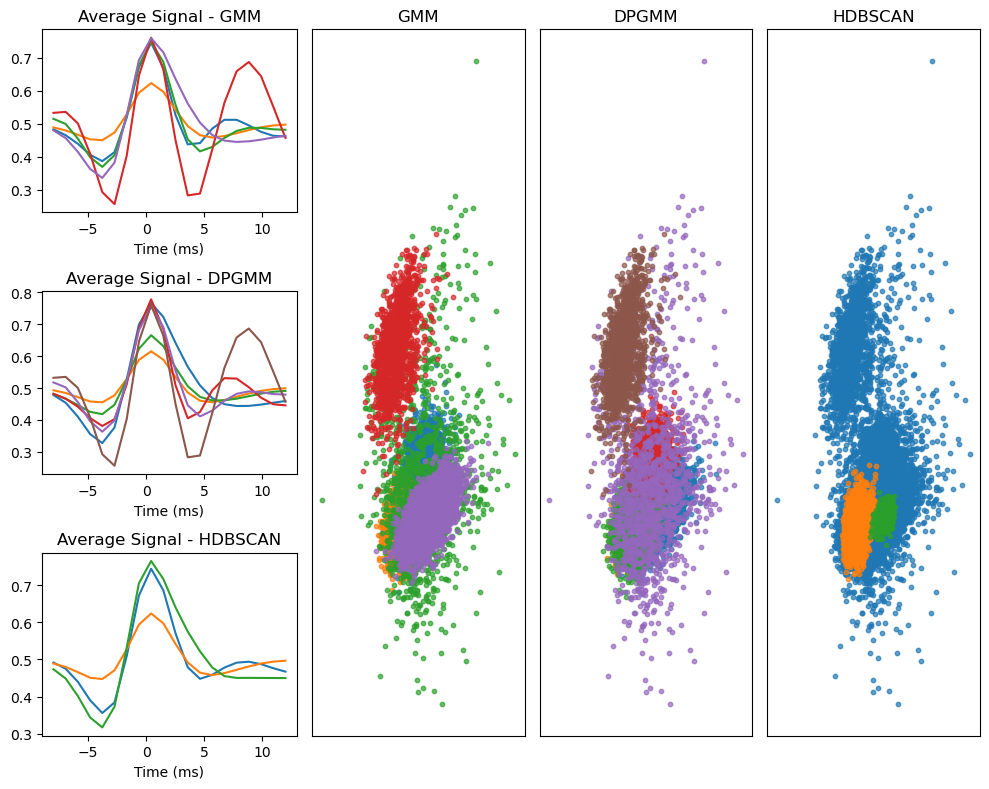

[0.1351054762971032, 0.02909589155553614, -0.10059919053627948]

In [15]:
draw_clustering_multi(all_xdata,all_emb,cls_labels_list,cluster_name = ['GMM','DPGMM','HDBSCAN'],method='pca',calc_silhouette=True,draw=True)

Using PCA, t-SNE, and UMAP for final visualization
Silhouette Score for Clustering GMM: 0.1351
Silhouette Score for Clustering DPGMM: 0.0291
Silhouette Score for Clustering HDBSCAN: -0.1006


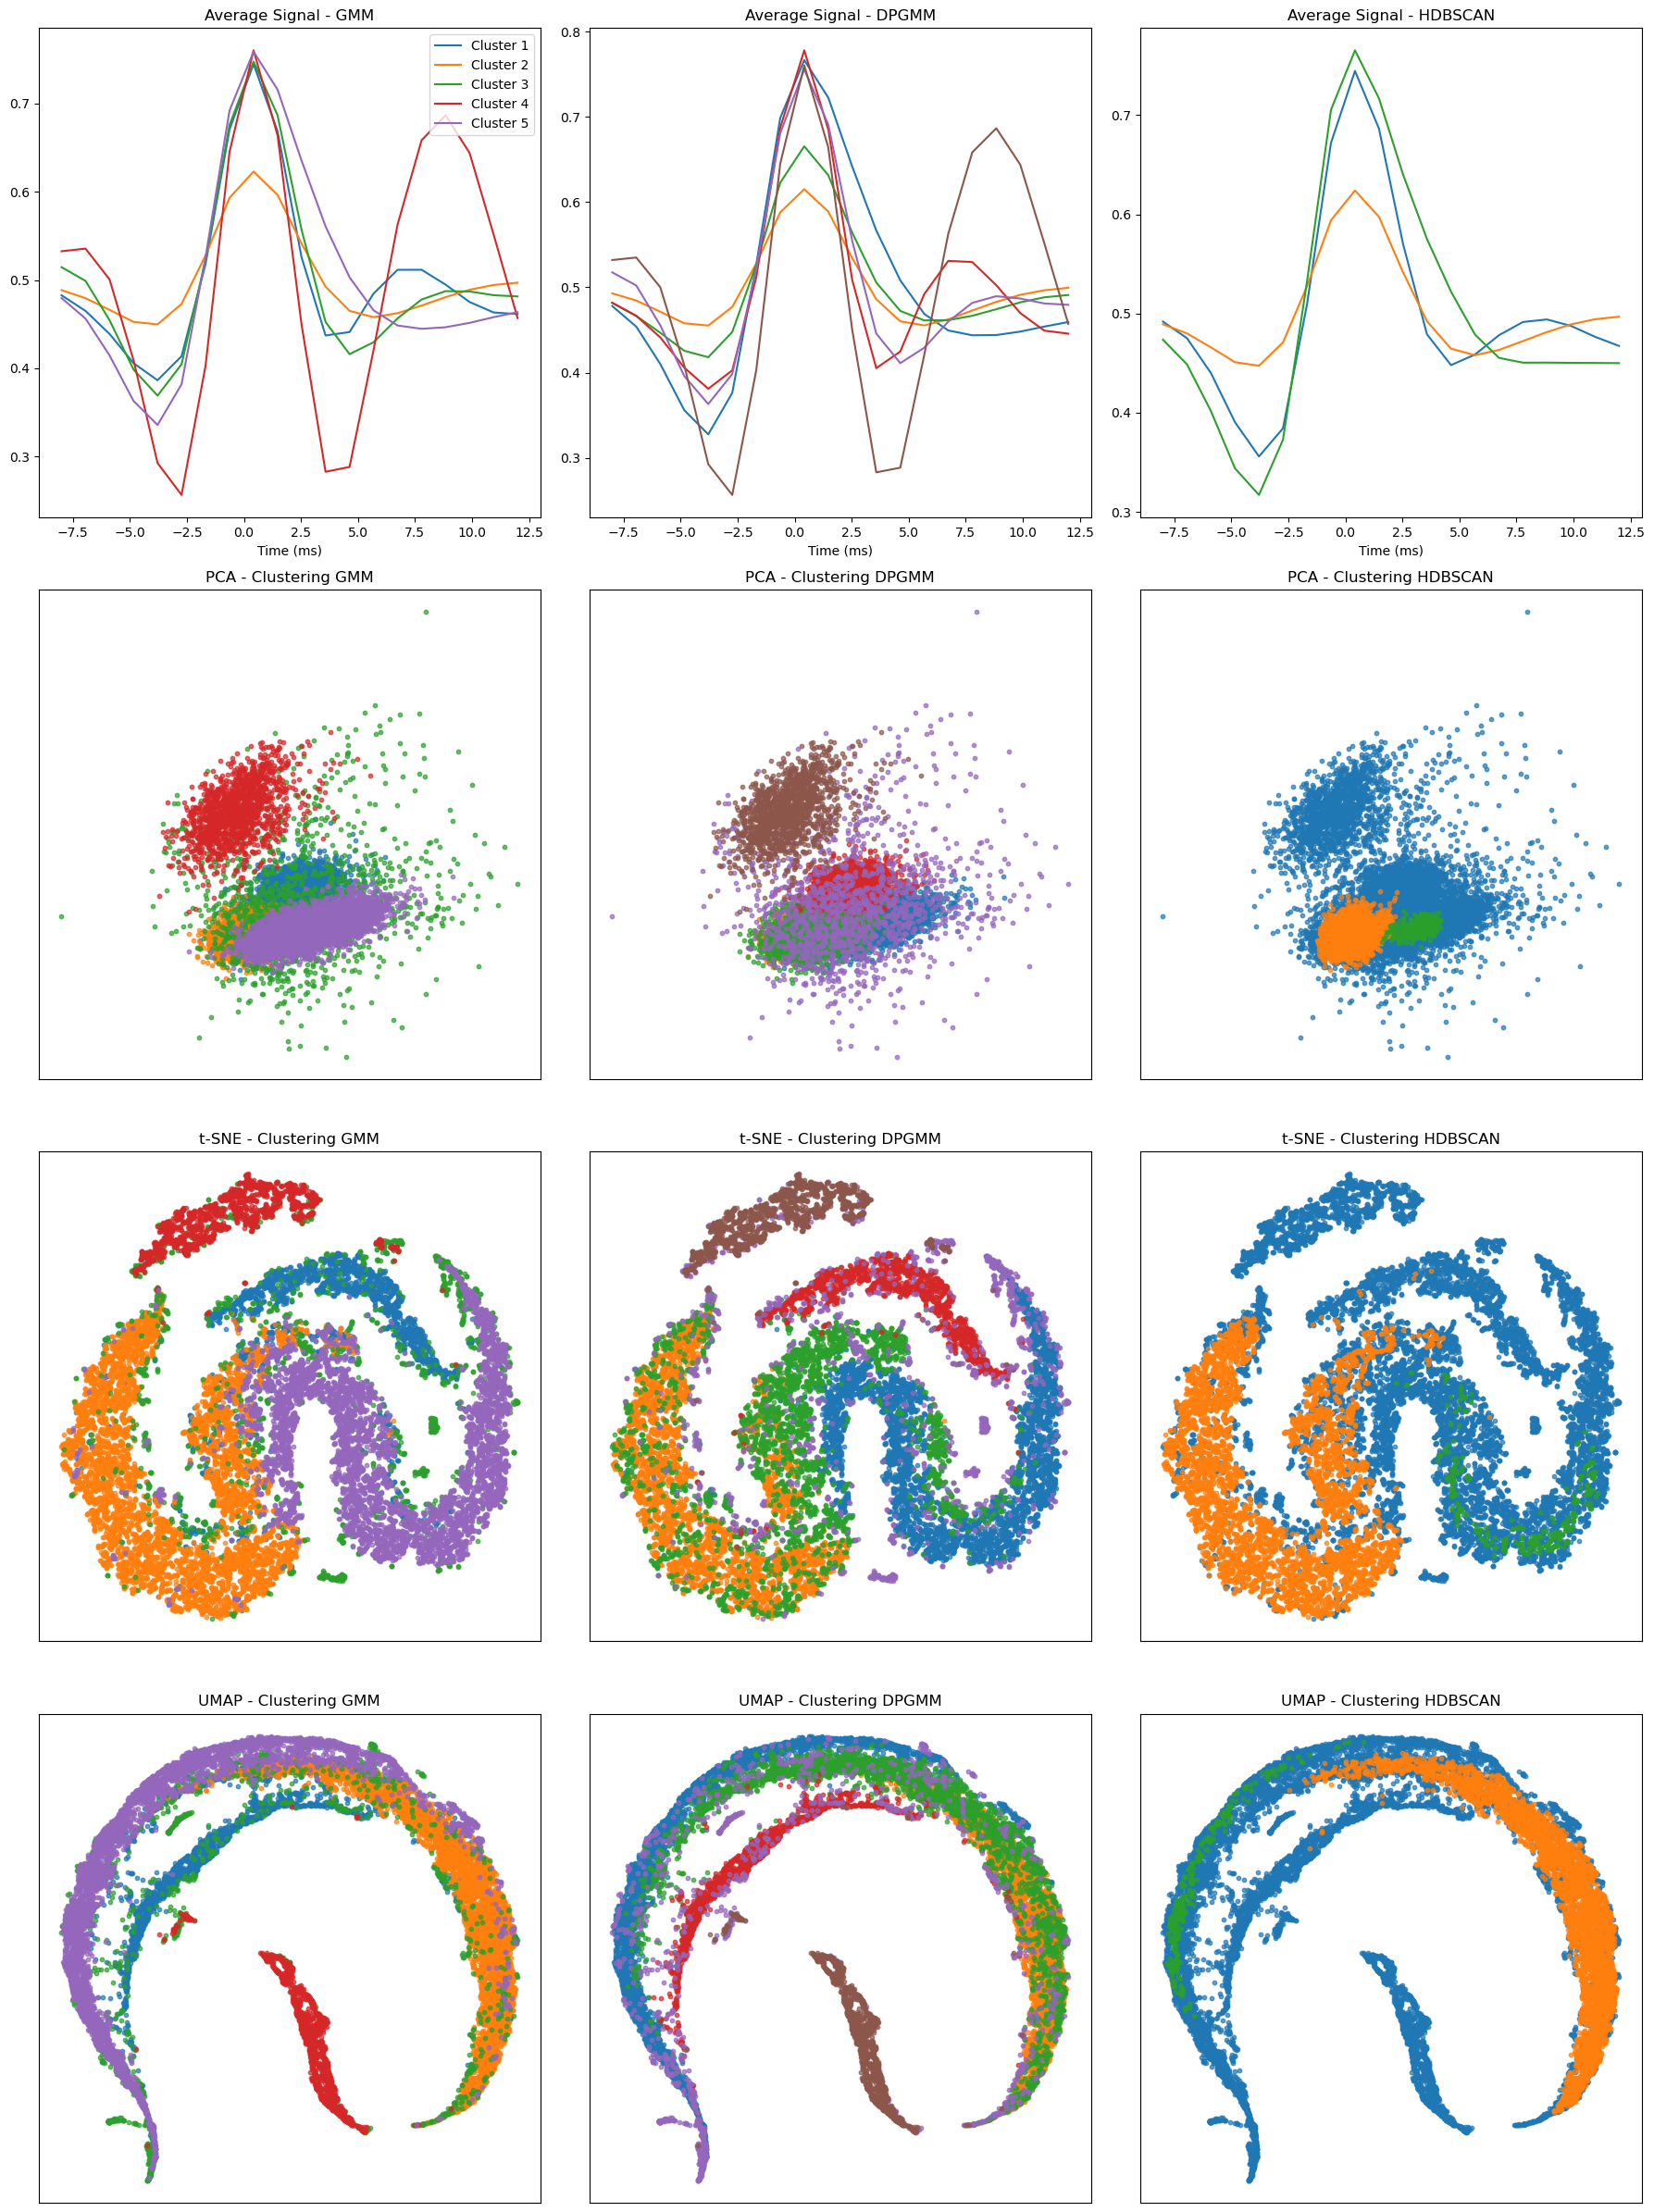

[0.1351054762971032, 0.029095891555536175, -0.10059919053627948]

In [16]:
draw_clustering_final(all_xdata,all_emb,cls_labels_list,cluster_name = ['GMM','DPGMM','HDBSCAN'],calc_silhouette=True,draw=True)

# Waveform Display and other sorters

In [16]:
try:
    we_true = si.load_waveforms(os.path.join(base_folder,f"waveforms_true"))
except:
    we_true = si.extract_waveforms(recording_f, sorting_true, folder=os.path.join(base_folder,f"waveforms_true"),overwrite = True, sparse=False, **job_kwargs)

d:\Applications\anaconda3\envs\ag\lib\site-packages\neo\rawio\tdtrawio.py:293: UserWarning: Could not identify sev files for channels [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8].
  warnings.warn(f"Could not identify sev files for channels {missing_sev_channels}.")


In [17]:
import spikeinterface.sorters as ss
sorter_names = ['kilosort4','tridesclous','mountainsort5','spykingcircus2']
sortings = {}
wes = {}
for name in sorter_names:
    sorting = ss.read_sorter_folder(os.path.join(base_folder,f"output_{name}"))
    try:
        we = si.load_waveforms(os.path.join(base_folder,f"waveforms_{name}"))
    except:
        we = si.extract_waveforms(recording_f, sorting, folder=os.path.join(base_folder,f"waveforms_{name}"),overwrite = None, sparse=False, **job_kwargs)
    sortings.update({name:sorting})
    wes.update({name:we})

d:\Applications\anaconda3\envs\ag\lib\site-packages\spikeinterface\core\base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.102.2 is recommended
  warnings.warn(
d:\Applications\anaconda3\envs\ag\lib\site-packages\neo\rawio\tdtrawio.py:293: UserWarning: Could not identify sev files for channels [1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8].
  warnings.warn(f"Could not identify sev files for channels {missing_sev_channels}.")


The datatsource is not found {'filenames': ['E:\\Work\\SpikeSorting\\kiehnlab\\Treadmill_clustered_txt\\Rec_treadmill_haloperidol_xx_-220317_Vglut2-ChR2-36_-220317-080745\\output_tridesclous\\sorter_output\\raw_signals_0.raw'], 'dtype': '<f4', 'sample_rate': 24414.0625, 'total_channel': 1, 'offset': 0}


d:\Applications\anaconda3\envs\ag\lib\site-packages\spikeinterface\core\base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.100.5 is recommended
  warnings.warn(
d:\Applications\anaconda3\envs\ag\lib\site-packages\spikeinterface\core\base.py:1117: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.100.6 is recommended
  warnings.warn(


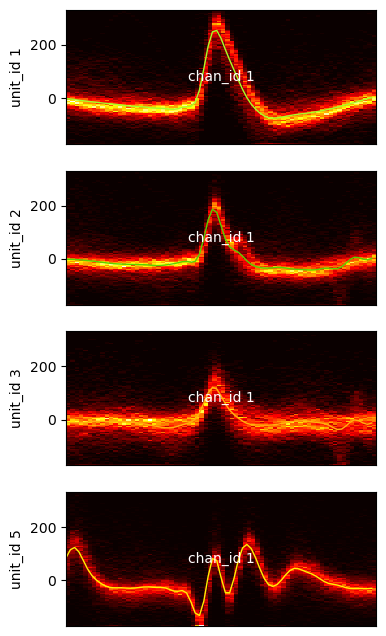

In [19]:
sw.plot_unit_waveforms_density_map(we_true, same_axis=False, backend = 'matplotlib',figsize = (4,8))

In [20]:
method_lists = [(None,'dpgmm'),(None,'hdbscan')]

In [24]:
we_true

MockWaveformExtractor: mock the old WaveformExtractor with SortingAnalyzer: 1 channels - 4 units - 1 segments - memory - has recording
Loaded 3 extensions: random_spikes, waveforms, templates

In [33]:
colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ]])

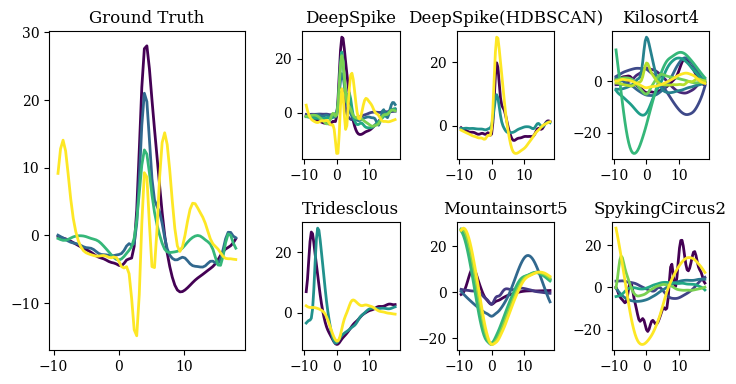

In [21]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import spikeinterface.widgets as sw

deep_names = {(None, 'dpgmm'):'DeepSpike', (None, 'hdbscan'):'DeepSpike(HDBSCAN)', ('bic', 'gmm'): 'DS_GMM'}
we_names = {'kilosort4':'Kilosort4', 'mountainsort5':'Mountainsort5', 'spykingcircus2': 'SpykingCircus2', 'tridesclous':'Tridesclous'}
# Create the figure with GridSpec to control the layout
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(2, 7, width_ratios=[2, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1])

# Plot we_true on the left side, spanning two rows
ax_we_true = fig.add_subplot(gs[:, 0])

unit_ids = we_true.sorting.get_unit_ids()
# Use a colormap to generate colors
cmap = plt.cm.viridis # You can use any colormap: viridis, jet, tab10, etc.
colors = cmap(np.linspace(0, 1, len(unit_ids)))

# Create the unit_colors dictionary
unit_colors = {unit_id: colors[i] for i, unit_id in enumerate(unit_ids)}
    
sw.plot_unit_templates(
    we_true, shade_templates=False, same_axis=True, plot_legend=False,unit_colors=unit_colors, set_title=False, backend='matplotlib', ax=ax_we_true
)
ax_we_true.set_title('Ground Truth')

# Plot wes_deep[name] in the second row, from columns 1 to 3
for i, name in enumerate(method_lists):
    ax = fig.add_subplot(gs[0, i + 1])
    
    unit_ids = wes_deep[name].sorting.get_unit_ids()
    # Use a colormap to generate colors
    colors = cmap(np.linspace(0, 1, len(unit_ids)))

    # Create the unit_colors dictionary
    unit_colors = {unit_id: colors[i] for i, unit_id in enumerate(unit_ids)}
    
    sw.plot_unit_templates(
        wes_deep[name], shade_templates=False, same_axis=True, plot_legend=False,unit_colors=unit_colors, set_title=False, backend='matplotlib', ax=ax
    )
    ax.set_title(f'{deep_names[name]}')

ax = fig.add_subplot(gs[0, 3])


unit_ids = wes['kilosort4'].sorting.get_unit_ids()
# Use a colormap to generate colors
colors = cmap(np.linspace(0, 1, len(unit_ids)))

# Create the unit_colors dictionary
unit_colors = {unit_id: colors[i] for i, unit_id in enumerate(unit_ids)}


sw.plot_unit_templates(
    wes['kilosort4'], shade_templates=False, same_axis=True, plot_legend=False,unit_colors=unit_colors, set_title=False, backend='matplotlib', ax=ax
)
ax.set_title('Kilosort4')
    
# Plot wes[name] in the first row, from columns 1 to 3
for i, name in enumerate(sorter_names[1:]):
    ax = fig.add_subplot(gs[1, i + 1])
    
    
    unit_ids = wes[name].sorting.get_unit_ids()
    # Use a colormap to generate colors
    colors = cmap(np.linspace(0, 1, len(unit_ids)))

    # Create the unit_colors dictionary
    unit_colors = {unit_id: colors[i] for i, unit_id in enumerate(unit_ids)}


    sw.plot_unit_templates(
        wes[name], shade_templates=False, same_axis=True, plot_legend=False,unit_colors=unit_colors, set_title=False, backend='matplotlib', ax=ax
    )
    ax.set_title(f'{we_names[name]}')


# Adjust layout for better spacing
plt.tight_layout()
# plt.savefig('../FINAL/NIPS_add/image/compare_sorters220317_Vglut2-ChR2-36_-220317-080745tab10.pdf',dpi=300,bbox_inches='tight')
plt.show()

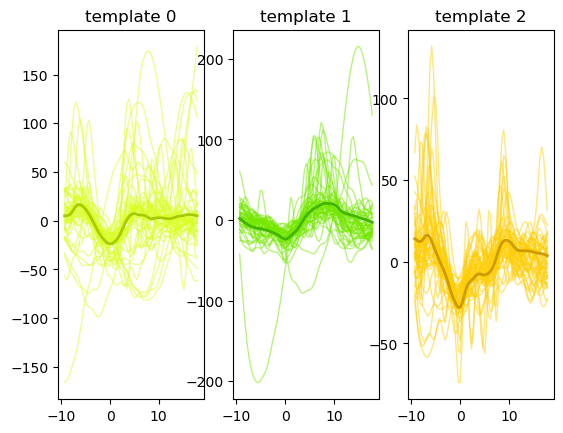

In [22]:
sw.plot_unit_waveforms(wes['spykingcircus2'], same_axis=False,x_offset_units = False, backend = 'matplotlib')